In [1]:
from pathlib import Path
import yaml
import os

root_dir = Path("/media") / "sharedData" / "data"
root_name = "glass-a2744"

catalogue_dir = root_dir / "2024_08_16_A2744_v4" / "glass_niriss" / "match_catalogues"

grizli_home_dir = root_dir / "2024_08_16_A2744_v4" / "grizli_home"
grizli_extraction_dir = grizli_home_dir / "Extractions_v2"
os.chdir(grizli_extraction_dir)

import matplotlib as mpl
aanda_columnwidth = 256.0748 / 72.27
aanda_textwidth = 523.5307 / 72.27
rc_fonts = {
    "font.family": "serif",
    "font.size": 9,
    "figure.figsize": (aanda_columnwidth, 3),
    "text.usetex": True,
    "ytick.right": True,
    "ytick.direction": "in",
    "ytick.minor.visible": True,
    "ytick.labelsize": 8,
    "xtick.top": True,
    "xtick.direction": "in",
    "xtick.minor.visible": True,
    "xtick.labelsize": 8,
    "axes.labelsize": 9,
    "axes.titlesize": 9,
    "legend.fontsize": 9,
    "text.latex.preamble": (
        r"""
    \usepackage{txfonts}
    """
    ),
}
mpl.rcParams.update(rc_fonts)

In [2]:
from grizli import jwst_utils, multifit
import logging
import shutil

jwst_utils.QUIET_LEVEL = logging.WARNING
jwst_utils.set_quiet_logging(jwst_utils.QUIET_LEVEL)

In [3]:
from astropy.table import Table, join, Column
import numpy as np

cat_v1 = Table.read(catalogue_dir / "classification_v1" / "compiled_catalogue_v1.fits")

In [4]:


# phot_cat = Table.read(grizli_home_dir / "Extractions" / "glass-a2744_phot.fits")

# from glass_niriss.pipeline import regen_catalogue
# from glass_niriss.sed import temp_chdir
# from astropy.io import fits

# seg_map = fits.getdata(grizli_home_dir / "Prep" / "glass-a2744-ir_seg.fits")
# # print (seg_map.is_file())
# # seg_map.byteswap().newbyteorder()
# # seg_map = seg_map.view(seg_map.dtype.newbyteorder()).astype(np.int32)
# seg_map = np.asarray(seg_map).astype(np.int32)
# #
# import drizzlepac
# print (drizzlepac.__version__)
# import photutils
# print (photutils.__version__)
# import numpy
# print (numpy.__version__)

# with temp_chdir(grizli_home_dir / "Prep"):
#     regen_catalogue(
#         new_seg_map=seg_map,
#         root="glass-a2744-ir",
#         # sci=str(grizli_home_dir / "Prep" / "glass-a2744-f200wn-clear_drc_sci.fits"),
#         # wht=str(grizli_home_dir / "Prep" / "glass-a2744-f200wn-clear_drc_wht.fits"),
#         # sci=str(grizli_home_dir / "Prep" / "glass-a2744-ir_drc_sci.fits"),
#         # wht=str(grizli_home_dir / "Prep" / "glass-a2744-ir_drc_wht.fits"),
#         suffix="test",
#     )

# # # test = join(phot_cat, cat_v1)


In [5]:
from itertools import product
from numpy.lib.recfunctions import structured_to_unstructured

filters = ["F115W","F150W","F200W"]
pas = ["72.0","341.0"]

beam_names = [f"{a},{b}" for b, a in product(pas, filters)]
coverage_names = [f"{b}_COVERAGE" for b in beam_names]
quality_names = [f"{b}_QUALITY" for b in beam_names]
new_names = [f"{b}_USE" for b in beam_names]

v2_cat = cat_v1.copy()

v2_cat.remove_columns(quality_names+new_names)

In [6]:
stage_1_BV = Table.read(grizli_home_dir / "classification-stage-2"/"catalogues"/"output" /"stage_1_Benedetta.fits")
compiled_v1 = Table.read(grizli_home_dir / "classification-stage-2"/"catalogues"/"output" /"compiled_catalogue_v1.fits")
# print (len(stage_1_BV))

# misplaced_ids = np.array([1,8,10,17,52,63,77,99,104,115,120,174])

# stage_1_BV = stage_1_BV[
#     ~(
#         (stage_1_BV["GRIZLI_REDSHIFT"]>=5)
#         & (stage_1_BV["ESTIMATED_REDSHIFT"]==stage_1_BV["GRIZLI_REDSHIFT"])
#     )
# ]
# print (len(stage_1_BV))
# stage_1_BV = stage_1_BV[
#     # ~(
#     #     (stage_1_BV["GRIZLI_REDSHIFT"]>=5)
#     #     & (stage_1_BV["ESTIMATED_REDSHIFT"]==stage_1_BV["GRIZLI_REDSHIFT"])
#     # )
#     ~((stage_1_BV["ID"].astype(int)<260) & (~np.isin(stage_1_BV["ID"].astype(int), misplaced_ids))) 
# ]
# print (len(stage_1_BV))
# stage_1_BV = stage_1_BV[
#     ~(stage_1_BV["UNRELIABLE_REDSHIFT"] | stage_1_BV["BAD_SEG_MAP"])
#     # & ()
#     # # ~(
#     # #     (stage_1_BV["GRIZLI_REDSHIFT"]>=5)
#     # #     & (stage_1_BV["ESTIMATED_REDSHIFT"]==stage_1_BV["GRIZLI_REDSHIFT"])
#     # # )
#     # ~((stage_1_BV["ID"].astype(int)<260) & (~np.isin(stage_1_BV["ID"].astype(int), misplaced_ids))) 
# ]
# print (len(stage_1_BV))
# # print (stage_1_BV)
# v1_idxs = np.isin(compiled_v1["NUMBER"],stage_1_BV["ID"])
# stage_1_BV = stage_1_BV[
#     compiled_v1[v1_idxs]["V1_CLASS"]>=4
# ]
# print (len(stage_1_BV))

lowz_bool = (compiled_v1["V1_CLASS"] >= 4) & (
    ((compiled_v1["REDSHIFT_USE"] < 6) & (compiled_v1["UNRELIABLE_REDSHIFT"] == False))
    | (compiled_v1["zphot"].mask)
)

stage_1_BV = stage_1_BV[np.isin(stage_1_BV["ID"],compiled_v1["NUMBER"][lowz_bool])]

print (len(stage_1_BV))

stage_1_BV.write(grizli_home_dir / "classification-stage-2"/"catalogues"/"output" /"stage_2_Benedetta.fits", overwrite=True)

1024


In [7]:
v2_out_dir = grizli_home_dir / "classification-stage-2"/"catalogues" / "compiled"
v2_out_dir.mkdir(exist_ok=True, parents=True)
new_cat_name = "internal_full_6.fits"
if not (v2_out_dir / new_cat_name / "test").is_file():
    stage_2_cats = grizli_home_dir.glob(
        "classification-stage-2/catalogues/output/stage_2*.fits"
    )
    p_names = []
    hist_list = []

    beam_quality_to_int = {"Unusable": 0, "Poor": 1, "Good": 2, "Excellent": 3}

    for c in stage_2_cats:
        p_cat = Table.read(c)
        p_name = c.stem.split("_")[-1]
        p_names.append(p_name)
        print(p_name)
        print (len(p_cat))
        p_cat.sort("SEG_ID")

        _, use_idxs,_ = np.intersect1d(np.array(v2_cat["SEG_ID"]), np.array(p_cat["SEG_ID"]), return_indices=True)

        # print (use_idxs.shape,use_idxs.sum())

        v2_cat["GRIZLI_REDSHIFT"][use_idxs] = p_cat["GRIZLI_REDSHIFT"]

        for n in coverage_names:
            v2_cat[n][use_idxs] = p_cat[n]

        for n in quality_names:
            v2_cat[f"{n}_{p_name}"] = np.nan
            v2_cat[f"{n}_{p_name}"][use_idxs] = [beam_quality_to_int[k] for k in p_cat[n]]

        comment_col = Column(name=f"COMMENTS_{p_name}", dtype=p_cat["COMMENTS"].dtype, length=len(v2_cat))
        comment_col[use_idxs] = p_cat["COMMENTS"]
        v2_cat.add_column(comment_col)

        v2_cat[f"ESTIMATED_REDSHIFT_{p_name}"] = np.nan
        v2_cat[f"ESTIMATED_REDSHIFT_{p_name}"][use_idxs] = p_cat["ESTIMATED_REDSHIFT"]

        v2_cat[f"Z_FLAG_{p_name}"] = np.nan
        flag = np.full(len(p_cat["ESTIMATED_REDSHIFT"]), np.nan)
        flag[np.isfinite(p_cat["ESTIMATED_REDSHIFT"])] = 2
        flag[p_cat["TENTATIVE_REDSHIFT"]] = 1
        flag[p_cat["UNRELIABLE_REDSHIFT"]] = 0
        v2_cat[f"Z_FLAG_{p_name}"][use_idxs] = flag
        # if p_name=="Peter":
        #     # print (p_cat["TENTATIVE_REDSHIFT"])
        #     # print (np.unique(np.array(p_cat["TENTATIVE_REDSHIFT"]), return_counts=True))
        #     # print (np.unique(np.array(p_cat["UNRELIABLE_REDSHIFT"]), return_counts=True))
        #     # print (np.unique(v2_cat["Z_FLAG_Peter"], return_counts=True))
        #     print (p_cat[75:85].pprint_all())
        #     print (flag[75:85])
        #     print (v2_cat["SEG_ID", f"Z_FLAG_{p_name}"][use_idxs][75:85])
        #     exit()
        # print (len(p_cat["UNRELIABLE_REDSHIFT"]))
        # v2_cat[f"Z_FLAG_{p_name}"][use_idxs] = [0 if k for k in p_cat["UNRELIABLE_REDSHIFT"]>0 if k]
        # v2_cat[f"Z_FLAG_{p_name}"][use_idxs][p_cat["UNRELIABLE_REDSHIFT"]] = 0
        # v2_cat[f"Z_FLAG_{p_name}"][use_idxs][p_cat["TENTATIVE_REDSHIFT"]] = 1
        # print (v2_cat[f"Z_FLAG_{p_name}"])

        hist_list.append(p_cat["ESTIMATED_REDSHIFT"][v2_cat[use_idxs][f"Z_FLAG_{p_name}"]==2])

    # from pprint import pprint

    z_val_names = [z for z in v2_cat.colnames if "ESTIMATED_REDSHIFT_" in z]
    z_flag_names = [z for z in v2_cat.colnames if "Z_FLAG_" in z]


    # print(z_flag_names)

    # print(v2_cat.colnames)

    v2_cat["Z_FLAG_ALL"] = -1000
    v2_cat["Z_EST_ALL"] = np.nan
    v2_cat["N_CLASS"] = 0

    Z_FLAG_DESCRIPTION = {
        "secure>=2, range(z_est)<=1%": 10,
        "secure>=2, range(z_est)>1%;<=5%": 9,
        "secure>=2, range(z_est)>5%": 8,
        # "All tentative, >=2 views, estimates consistent within 1%, agrees with zphot/zspec within 5%": 7,
        "tentative>=2, range(z_est)<=1%": 7,
        "tentative>=2, range(z_est)>1%;<=5%": 6,
        "tentative>=2, range(z_est)>5%": 5,
        "unreliable>=2": -10,
        "secure>=1, tentative==1, range(z_est[secure])<=5%": 4,
        "secure>=1, tentative==1, range(z_est[secure])>5%": 3,
        "tentative>1, secure==1, range(z_est[secure])<=5%": 2,
        "tentative>1, secure==1, range(z_est[secure])>5%": 1,
        "secure>=1, unreliable==1": 0,
        "tentative>=1, unreliable==1": -1,
        "unreliable>=1, secure|tentative>=1": -2,
        "n<2": -33,
        "UNCLASSIFIED": -99,
        "ERROR": -1000,
        # "All tentative, >=2 views, estimates consistent within 1%": 6,
        # "All tentative, >=2 views, estimates consistent within 1-5%": 5,
        # "All tentative, >=2 views, estimates inconsistent within 5%": 4,
    }

    Z_FLAG_INV = {v: k for k, v in Z_FLAG_DESCRIPTION.items()}
    print(Z_FLAG_INV)

    for i, row in enumerate(v2_cat[:]):
        if row["V1_CLASS"] <= 3:
            v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION["UNCLASSIFIED"]
            continue
        # np.isfinite?
        z_vals = structured_to_unstructured(np.array(row[z_val_names]))
        z_flags = structured_to_unstructured(np.array(row[z_flag_names]))

        fin = np.isfinite(z_flags)
        v2_cat["N_CLASS"][i] = np.sum(fin)
        # print (fin)
        if np.sum(fin) >= 2:
            if np.all(z_flags[fin] == 2):
                # print ("y")
                # print (f"ID={row["ID"]}, z={z_vals[fin]}")
                # print (np.ptp(z_vals[fin]), 0.01*np.nanmedian(z_vals))
                if np.ptp(z_vals[fin]) <= 0.01 * np.nanmedian(z_vals):
                    v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                    v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
                        "secure>=2, range(z_est)<=1%"
                    ]
                elif np.ptp(z_vals[fin]) <= 0.05 * np.nanmedian(z_vals):
                    v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                    v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
                        "secure>=2, range(z_est)>1%;<=5%"
                    ]
                else:
                    v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                    v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
                        "secure>=2, range(z_est)>5%"
                    ]

            elif np.all(z_flags[fin] == 1):
                # print ("y")
                # print (f"ID={row["ID"]}, z={z_vals[fin]}")
                # print (np.ptp(z_vals[fin]), 0.01*np.nanmedian(z_vals))
                # if (np.ptp(z_vals[fin]) <= 0.01 * np.nanmedian(z_vals)) and (
                #     np.abs(np.nanmedian(z_vals) - row["zphot"]) <= 0.01 * row["zphot"]
                # ):
                #     v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                #     v2_cat["Z_FLAG_ALL"][i] = 7
                if np.ptp(z_vals[fin]) <= 0.01 * np.nanmedian(z_vals):
                    v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                    v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
                        "tentative>=2, range(z_est)<=1%"
                    ]
                elif np.ptp(z_vals[fin]) <= 0.05 * np.nanmedian(z_vals):
                    v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                    v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
                        "tentative>=2, range(z_est)>1%;<=5%"
                    ]
                else:
                    v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                    v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
                        "tentative>=2, range(z_est)>5%"
                    ]

            elif (np.sum(z_flags[fin] == 1) == 1) and (np.sum(z_flags[fin] == 2) >= 1):
                if np.ptp(z_vals[fin]) <= 0.05 * np.nanmedian(z_vals):
                    v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                    v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
                        "secure>=1, tentative==1, range(z_est[secure])<=5%"
                    ]
                else:
                    v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                    v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
                        "secure>=1, tentative==1, range(z_est[secure])>5%"
                    ]

            elif (np.sum(z_flags[fin] == 1) > 1) and (np.sum(z_flags[fin] == 2) == 1):
                if np.ptp(z_vals[fin]) <= 0.05 * np.nanmedian(z_vals):
                    v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                    v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
                        "tentative>1, secure==1, range(z_est[secure])<=5%"
                    ]
                else:
                    v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                    v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
                        "tentative>1, secure==1, range(z_est[secure])>5%"
                    ]

            elif (np.sum(z_flags[fin] == 2) >= 1) and (np.sum(z_flags[fin] == 0) == 1):
                v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION["secure>=1, unreliable==1"]

            elif (np.sum(z_flags[fin] == 1) >= 1) and (np.sum(z_flags[fin] == 0) == 1):
                v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION["tentative>=1, unreliable==1"]

            elif np.all(z_flags[fin] == 0):
                v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION["unreliable>=2"]

            elif np.sum(z_flags[fin] == 0) >= 1:
                v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
                v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION[
                    "unreliable>=1, secure|tentative>=1"
                ]

            else:
                pass
        else:
            v2_cat["Z_EST_ALL"][i] = np.nanmedian(z_vals[fin])
            v2_cat["Z_FLAG_ALL"][i] = Z_FLAG_DESCRIPTION["n<2"]

    # print (f"ID={row["ID"]}, z={np.nanmedian(z_vals):.3f}, flags={np.nanmean(z_flags)}")
    # with np.printoptions(precision=3, suppress=True,floatmode='fixed'):
    #     print (z_vals)
    #     print (z_flags)
    # # print (row[z_val_names])
    # # print (row[z_flag_names])
    v2_cat.write(v2_out_dir / new_cat_name, overwrite=True)
else:
    v2_cat = Table.read(v2_out_dir / new_cat_name)


Benedetta
1024
Guido
560
Matt
220
Nicolo
450
Peter
582
Sofia
559
Tommaso
184
Xianlong
450
Yechi
550
{10: 'secure>=2, range(z_est)<=1%', 9: 'secure>=2, range(z_est)>1%;<=5%', 8: 'secure>=2, range(z_est)>5%', 7: 'tentative>=2, range(z_est)<=1%', 6: 'tentative>=2, range(z_est)>1%;<=5%', 5: 'tentative>=2, range(z_est)>5%', -10: 'unreliable>=2', 4: 'secure>=1, tentative==1, range(z_est[secure])<=5%', 3: 'secure>=1, tentative==1, range(z_est[secure])>5%', 2: 'tentative>1, secure==1, range(z_est[secure])<=5%', 1: 'tentative>1, secure==1, range(z_est[secure])>5%', 0: 'secure>=1, unreliable==1', -1: 'tentative>=1, unreliable==1', -2: 'unreliable>=1, secure|tentative>=1', -33: 'n<2', -99: 'UNCLASSIFIED', -1000: 'ERROR'}


In [8]:
print("\nGalaxies classified in Stage 2:\n")

n_class = np.unique(
    np.array(v2_cat["N_CLASS"][v2_cat["V1_CLASS"] >= 4]), return_counts=True
)
for v, c in zip(*n_class):
    print(f"#Classifications = {v:<5} Counts = {c}")

print("")

flag_types = np.unique(
    np.array(v2_cat["Z_FLAG_ALL"][v2_cat["V1_CLASS"] >= 4]), return_counts=True
)
for v, c in zip(*flag_types):
    print(f"Flag = {v:<5} Counts = {c:<5} Description: {Z_FLAG_INV[v]}")

print("\nlow_z_cat:")
n_class = np.unique(
    np.array(
        v2_cat["N_CLASS"][
            (v2_cat["V1_CLASS"] >= 4)
            & (
                (
                    (v2_cat["REDSHIFT_USE"] < 6)
                    & (v2_cat["UNRELIABLE_REDSHIFT"] == False)
                )
                | (~np.isfinite(v2_cat["zphot"]))
            )
        ]
    ),
    return_counts=True,
)
for v, c in zip(*n_class):
    print(f"#Classifications = {v:<5} Counts = {c}")

print("\nhigh_z_cat:")
n_class = np.unique(
    np.array(
        v2_cat["N_CLASS"][
            (v2_cat["V1_CLASS"] >= 4)
            & (
                (
                    (v2_cat["REDSHIFT_USE"] >= 6)
                    | (v2_cat["UNRELIABLE_REDSHIFT"] == True)
                )
                & (np.isfinite(v2_cat["zphot"]))
            )
        ]
    ),
    return_counts=True,
)
for v, c in zip(*n_class):
    print(f"#Classifications = {v:<5} Counts = {c}")

print(
    np.intersect1d(
        np.array(
            v2_cat["ID"][
                (v2_cat["V1_CLASS"] >= 4)
                & (
                    (
                        (v2_cat["REDSHIFT_USE"] >= 6)
                        | (v2_cat["UNRELIABLE_REDSHIFT"] == True)
                    )
                    & (np.isfinite(v2_cat["zphot"]))
                )
            ]
        ),
        np.array(
            v2_cat["ID"][
                (v2_cat["V1_CLASS"] >= 4)
                & (
                    (
                        (v2_cat["REDSHIFT_USE"] < 6)
                        & (v2_cat["UNRELIABLE_REDSHIFT"] == False)
                    )
                    | (~np.isfinite(v2_cat["zphot"]))
                )
            ]
        ),
    )
)

print(
    len(
        v2_cat["ID"][
            ((v2_cat["Z_FLAG_ALL"] == Z_FLAG_DESCRIPTION["secure>=2, range(z_est)<=1%"]) | (v2_cat["Z_FLAG_ALL"] == Z_FLAG_DESCRIPTION["secure>=2, range(z_est)>1%;<=5%"]))
            & (~np.isfinite(v2_cat["zspec"]))
        ]
    )
)


Galaxies classified in Stage 2:

#Classifications = 2     Counts = 1541
#Classifications = 3     Counts = 499

Flag = -10   Counts = 410   Description: unreliable>=2
Flag = -2    Counts = 60    Description: unreliable>=1, secure|tentative>=1
Flag = -1    Counts = 300   Description: tentative>=1, unreliable==1
Flag = 0     Counts = 456   Description: secure>=1, unreliable==1
Flag = 1     Counts = 5     Description: tentative>1, secure==1, range(z_est[secure])>5%
Flag = 2     Counts = 16    Description: tentative>1, secure==1, range(z_est[secure])<=5%
Flag = 3     Counts = 104   Description: secure>=1, tentative==1, range(z_est[secure])>5%
Flag = 4     Counts = 194   Description: secure>=1, tentative==1, range(z_est[secure])<=5%
Flag = 5     Counts = 7     Description: tentative>=2, range(z_est)>5%
Flag = 6     Counts = 2     Description: tentative>=2, range(z_est)>1%;<=5%
Flag = 7     Counts = 46    Description: tentative>=2, range(z_est)<=1%
Flag = 8     Counts = 39    Description: se

In [9]:
print(
    v2_cat["ID"][
        (
            (v2_cat["Z_FLAG_ALL"] == Z_FLAG_DESCRIPTION["secure>=2, range(z_est)<=1%"])
            | (
                v2_cat["Z_FLAG_ALL"]
                == Z_FLAG_DESCRIPTION["secure>=2, range(z_est)>1%;<=5%"]
            )
        )
        & (v2_cat["Z_EST_ALL"]>=1.85)
        & (v2_cat["Z_EST_ALL"]<=1.95)
    ]
)

 ID 
----
 438
 594
 616
1221
1851
1866
1925
1983
2355
2363
2408
2434
2744
2897
2938
3015
3045
3061
3214
3266
3384


(0.0, 60.9)

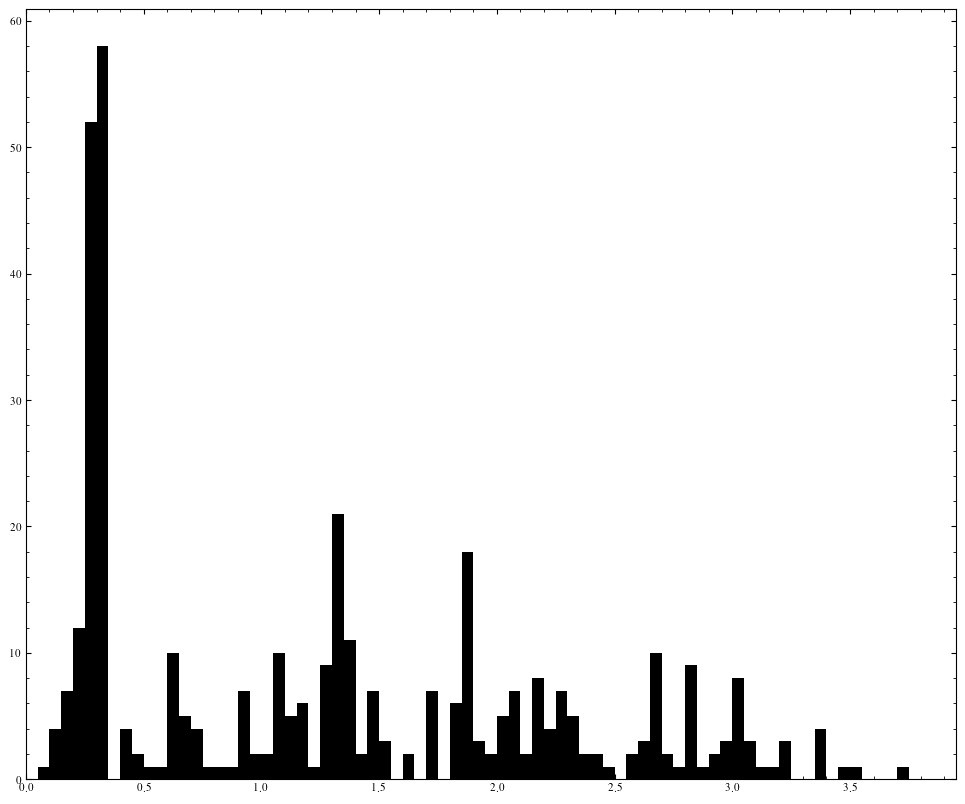

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(12, 10))

z_bins = np.arange(0, 4, 0.05)
axs.hist(v2_cat["Z_EST_ALL"][v2_cat["Z_FLAG_ALL"] >= 9], bins=z_bins, color="k")
axs.set_xlim(z_bins[0],z_bins[-1])
y_lims = axs.get_ylim()

# h_alpha_lims = [
#     [0.543,0.954],
#     [1.026,1.545],
#     [1.667,2.391],
# ]
# OIII_lims = [
#     [1.032,1.574],
#     [1.668,2.353],
#     [2.513,3.466],
# ]
# for l in h_alpha_lims:
#     axs.fill_betweenx(y_lims, *l, color="b", alpha=0.2, edgecolor="none")
# for l in OIII_lims:
#     axs.fill_betweenx(y_lims, *l, color="r", alpha=0.2, edgecolor="none")

axs.set_ylim(y_lims)

(16.02412772593332, 31.804762526190476)

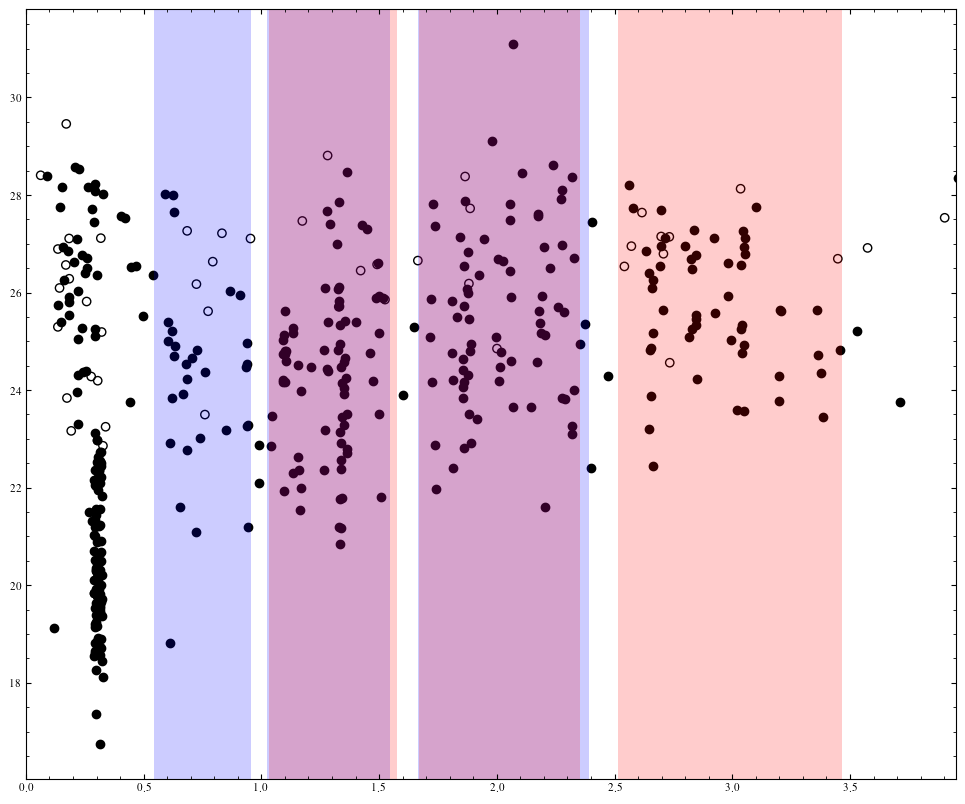

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(12, 10))

secure = v2_cat["Z_FLAG_ALL"] >= 9
tentative = (v2_cat["Z_FLAG_ALL"] == 7) | (v2_cat["Z_FLAG_ALL"] == 6)

z_bins = np.arange(0, 4, 0.05)

axs.scatter(
    v2_cat["Z_EST_ALL"][secure],
    v2_cat["MAG_AUTO"][secure],
    color="k",
)
axs.scatter(
    v2_cat["Z_EST_ALL"][tentative],
    v2_cat["MAG_AUTO"][tentative],
    color="k",
    facecolor="none",
    marker="o"
)
axs.set_xlim(z_bins[0], z_bins[-1])
y_lims = axs.get_ylim()

h_alpha_lims = [
    [0.543, 0.954],
    [1.026, 1.545],
    [1.667, 2.391],
]
OIII_lims = [
    [1.032, 1.574],
    [1.668, 2.353],
    [2.513, 3.466],
]
for l in h_alpha_lims:
    axs.fill_betweenx(y_lims, *l, color="b", alpha=0.2, edgecolor="none")
for l in OIII_lims:
    axs.fill_betweenx(y_lims, *l, color="r", alpha=0.2, edgecolor="none")

axs.set_ylim(y_lims)

In [12]:
ax
axs[0].hist(hist_list, z_bins,stacked=True)
for h, n in zip(hist_list, p_names):
    axs[1].hist(h, z_bins,label=n, alpha=0.5)

axs[1].set_xlabel("Redshift")
axs[1].set_xlim(0,10)
plt.legend()
plt.show()

# v2_cat["ESTIMATED_REDSHIFT"] = np.nan
v2_cat["ESTIMATED_REDSHIFT"] = np.nan
z_flags = structured_to_unstructured(
    np.array(v2_cat[[z for z in v2_cat.colnames if "Z_FLAG_" in z]])
)
z_vals = structured_to_unstructured(
    np.array(v2_cat[[z for z in v2_cat.colnames if "ESTIMATED_REDSHIFT_" in z]])
)
v2_cat["ESTIMATED_REDSHIFT_TOTAL"] = np.nanmean((z_flags == 2) * z_vals, axis=1)
v2_cat["Z_FLAG_TOTAL"] = np.nanmean(z_flags, axis=1)


# v2_cat["ESTIMATED_REDSHIFT"]

z_min = 1.8
z_max = 2.0

# v2_cat[(z_min<=v2_cat["ESTIMATED_REDSHIFT"]) & (z_max>=v2_cat["ESTIMATED_REDSHIFT"])][:]
# for row in v2_cat[(1.32<=v2_cat["ESTIMATED_REDSHIFT"]) & (1.36>=v2_cat["ESTIMATED_REDSHIFT"])]:
#     print (row["NUMBER"],row["ESTIMATED_REDSHIFT"])

# for row in v2_cat:
# usable_redshifts = [v2_cat[""]]

redshift_cols = (
    ["SEG_ID"]
    + [z for z in v2_cat.colnames if "Z_FLAG_" in z]
    + [z for z in v2_cat.colnames if "ESTIMATED_REDSHIFT_" in z]
)
# print (np.nansum(v2_cat["ESTIMATED_REDSHIFT"]>0)np.nansum(v2_cat["ESTIMATED_REDSHIFT"]>0)
# print(
#     [
#         f"{a:.2f}: {b}"
#         for a, b in zip(
#             *np.unique(np.array(v2_cat["Z_FLAG_TOTAL"]), return_counts=True)
#         )
#     ]
# )
# # v2_cat["Z_FLAG_TOTAL"]
# redshift_flag_name = "TOTAL"
test_cat = v2_cat[
    # (v2_cat["Z_FLAG_Peter"] == 2)
    (v2_cat["Z_FLAG_TOTAL"] == 2)
    # & (v2_cat[f"ESTIMATED_REDSHIFT_{redshift_flag_name}"] >= z_min)
    # & (v2_cat[f"ESTIMATED_REDSHIFT_{redshift_flag_name}"] <= z_max)
    # v2_cat["NUMBER"].astype(int)==3310
]# ][redshift_cols]
print (len(test_cat))
# # print (test_cat.colnames)
# test_cat[redshift_cols][:].pprint_all()
# for r in test_cat["NUMBER"]:
#     print (r)
# print (test_cat["NUMBER", "RA", "DEC"].pprint_all())


# # Double check Xianlong's output - e.g. 2277,2542,2782 are definitely wrong redshift

# # 2972 is a case where existing spec-z is wrong

NameError: name 'ax' is not defined

438
594
616
1221
1297
1333
1851
1866
1925
1983
2355


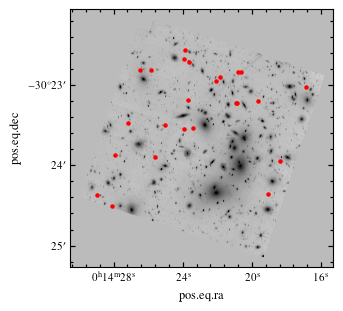

In [ ]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
import astropy.visualization as astrovis

z_min = 1.85
z_max = 2.

z_flag_name = "TOTAL"

plot_cat = v2_cat[
    (v2_cat["Z_FLAG_TOTAL"] == 2)
    & (v2_cat[f"ESTIMATED_REDSHIFT_{z_flag_name}"] > z_min)
    & (v2_cat[f"ESTIMATED_REDSHIFT_{z_flag_name}"] <= z_max)
]

img_path = (
    root_dir
    / "2024_08_16_A2744_v4"
    / "grizli_home"
    / "Prep"
    / "glass-a2744-ir_drc_sci.fits"
)

with fits.open(img_path) as img_hdul:
    img_wcs = WCS(img_hdul[0])

    fig, ax = plt.subplots(
        # figsize=(plot_utils.aanda_columnwidth, plot_utils.aanda_columnwidth),
        constrained_layout=True,
        subplot_kw={"projection": img_wcs},
    )
    ax.imshow(
        img_hdul[0].data,
        norm=astrovis.ImageNormalize(
            img_hdul[0].data,
            interval=astrovis.PercentileInterval(99.9),
            stretch=astrovis.LogStretch(),
        ),
        cmap="binary",
        origin="lower",
    )

ax.scatter(
    plot_cat["RA"],
    plot_cat["DEC"],
    transform=ax.get_transform("world"),
    s=5,
    c="red"
)

# missing_ids = ~np.isin(cat_v2["NUMBER"],cat_v1["ID"])

# cat_v2["V1_CLASS"][missing_ids] = 0

# for q in new_names:
#     cat_v2[q] = 1
#     cat_v2[q][missing_ids] = 0

# # cat_v2

plot_cat["NUMBER"]


In [ ]:
# misplaced_ids = np.array([1,8,10,17,52,63,77,99,104,115,120,174])

# for i_p, pa in enumerate(pas):
#     unusable_f150w_flag = (
#         (cat_v2[f"F150W,{pa}_QUALITY"]=="Unusable")
#         & (cat_v2[f"F150W,{pa}_COVERAGE"]!=0)
#         & ((cat_v2["NUMBER"].astype(int)<260) & (~np.isin(cat_v2["NUMBER"].astype(int), misplaced_ids))) 

#     )
#     for filt in filters:
#         cat_v2[f"{filt},{pa}_USE"][unusable_f150w_flag] = 0

#     unusable_f115w_flag = (
#         (cat_v2[f"F115W,{pa}_QUALITY"]=="Unusable")
#         & (cat_v2[f"F115W,{pa}_COVERAGE"]!=0)
#         & ((cat_v2["NUMBER"].astype(int)<260) & (~np.isin(cat_v2["NUMBER"].astype(int), misplaced_ids)))
#     )
#     for filt in filters:
#         cat_v2[f"{filt},{pa}_USE"][unusable_f115w_flag] = 0
#         # cat_v2[f"{filt},{pa}_USE"][np.isin(cat_v2["NUMBER"],cat_v1["ID"][unusable_f115w_flag])] = 0

# # cat_v2["ESTIMATED_REDSHIFT"] = np.nan
# # cat_v2["ESTIMATED_REDSHIFT"][np.isin(cat_v2["NUMBER"],cat_v1["ID"])] = cat_v1["ESTIMATED_REDSHIFT"]

# # print (np.where(cat_v2["NUMBER"]==cat_v1["ID"]))
# # a,b,v1_to_v2_idx = np.intersect1d(cat_v2["NUMBER"],cat_v1["ID"], return_indices=True)
# # cat_v2["ESTIMATED_REDSHIFT"][b] = cat_v1["ESTIMATED_REDSHIFT"]
# # cat_v2


In [ ]:
# for i_p, pa in enumerate(pas):
#     for filt in filters:
#         unusable_flag = (
#             ((cat_v2["NUMBER"].astype(int)>=260) | (np.isin(cat_v2["NUMBER"].astype(int), misplaced_ids))) &
#             (
#                 (cat_v2[f"{filt},{pa}_QUALITY"]=="Unusable")
#                 | (cat_v2[f"{filt},{pa}_COVERAGE"]==0)
#             )
#         )
#         cat_v2[f"{filt},{pa}_USE"][unusable_flag] = 0
        
# # cat_v2

In [ ]:
# # V1_CLASS:
# # 0 - Extraction not possible
# # 1 - Unusable in all beams
# # 2 - Star
# # 3 - Bad seg map
# # 4 - Some bad beams, re-extract
# # 5 - No bad beams, re-extract
# # 6 - No bad beams, specz ~= estimated z (don't re-extract)

# for row in cat_v2[~cat_v2["COMMENTS"].mask]:
#     if "star" in row["COMMENTS"]:
#         cat_v2["V1_CLASS"][np.isin(cat_v2["NUMBER"],int(row["ID"]))] = 2
#     elif "unusable" in row["COMMENTS"]:
#         # print (row)
#         if "72" in row["COMMENTS"]:
#             for filt in filters:
#                 cat_v2[f"{filt},72.0_USE"][np.isin(cat_v2["NUMBER"],int(row["ID"]))] = 0
#         elif "341" in row["COMMENTS"]:
#             for filt in filters:
#                 cat_v2[f"{filt},341.0_USE"][np.isin(cat_v2["NUMBER"],int(row["ID"]))] = 0
#     elif "remove" in row["COMMENTS"]:
#         for pa in pas:
#             for filt in filters:
#                 cat_v2[f"{filt},{pa}_USE"][np.isin(cat_v2["NUMBER"],int(row["ID"]))] = 0
#     else:
#         pass
#         # print (row["ID"],row["COMMENTS"])

# cat_v2["V1_CLASS"][
#     np.all(structured_to_unstructured(np.array(cat_v2[new_names]))==0, axis=1)
#     & (cat_v2["V1_CLASS"]==10)
# ] = 1

# cat_v2["REDSHIFT_USE"] = cat_v2["ESTIMATED_REDSHIFT"]

# # cat_v2

# # print (np.unique(cat_v2["V1_CLASS"], return_counts=True))

In [ ]:
# cat_v2["V1_CLASS"][(cat_v2["BAD_SEG_MAP"] == True) & (cat_v2["V1_CLASS"] == 10)] = 3


# cat_v2["V1_CLASS"][
#     np.any(structured_to_unstructured(np.array(cat_v2[new_names])) == 0, axis=1)
#     & (cat_v2["V1_CLASS"] == 10)
# ] = 4

# cat_v2["V1_CLASS"][
#     np.all(structured_to_unstructured(np.array(cat_v2[new_names])) == 1, axis=1)
#     & (cat_v2["V1_CLASS"] == 10)
# ] = 5


# cat_v2["V1_CLASS"][
#     (cat_v2["V1_CLASS"] == 5)
#     # (cat_v2["ESTIMATED_REDSHIFT"] == cat_v2["GRIZLI_REDSHIFT"])
#     & (cat_v2["zspec"] > 0)
#     & (np.abs(cat_v2["ESTIMATED_REDSHIFT"]/cat_v2["GRIZLI_REDSHIFT"]-1)<=0.005)
#     # & (~np.any(structured_to_unstructured(np.array(cat_v2[new_names])) == 0))
# ] = 6

# # print(np.nansum(cat_v2["zspec"] > 0))

# # print (np.abs(cat_v2["ESTIMATED_REDSHIFT"]/cat_v2["GRIZLI_REDSHIFT"])[cat_v2["V1_CLASS"]==6])
# # print (quality_names)
# # print (np.nansum(
# #     (cat_v1[quality_names[1]]=="Unusable") &
# #     (cat_v1[coverage_names[1]]!=0)
# # ))

# # print (np.unique(cat_v2["V1_CLASS"], return_counts=True))

In [ ]:
# print("Statistics:")
# print(f"Total: {len(cat_v2)}")
# print(
#     f"Usable in at least one beam: {np.nansum(~np.all(structured_to_unstructured(np.array(cat_v2[new_names]))==0, axis=1))}"
# )
# print(
#     f"Usable in all beams: {np.nansum(np.all(structured_to_unstructured(np.array(cat_v2[new_names]))==1, axis=1))}"
# )
# print("")
# print(f"No extraction possible: {np.nansum(cat_v2["V1_CLASS"]==0)}")
# print(f"Unusable in all orientations: {np.nansum(cat_v2["V1_CLASS"]==1)}")
# print(f"Star: {np.nansum(cat_v2["V1_CLASS"]==2)}")
# print(f"Bad seg map: {np.nansum(cat_v2["V1_CLASS"]==3)}")
# print(f"Unusable in some orientations: {np.nansum(cat_v2["V1_CLASS"]==4)}")
# print(f"Good in all orientations: {np.nansum(cat_v2["V1_CLASS"]==5)}")
# print(f"Good in all orientations, and specz: {np.nansum(cat_v2["V1_CLASS"]==6)}")
# print("")

# use_cat = cat_v2[cat_v2["V1_CLASS"] >= 4]

# print (np.nansum(use_cat["UNRELIABLE_REDSHIFT"]))
# print (np.nansum(use_cat["zphot"]>=3))
# print (np.nansum(use_cat["zphot"]<2))


# print ("change grizli to highz:", np.nansum((use_cat["GRIZLI_REDSHIFT"]!=use_cat["ESTIMATED_REDSHIFT"]) & (use_cat["ESTIMATED_REDSHIFT"]>=6)))
# print ("change photz to highz:", np.nansum((use_cat["zphot"]<6) & (use_cat["ESTIMATED_REDSHIFT"]>=6)))
# print (np.nansum((use_cat["UNRELIABLE_REDSHIFT"] == True) & (np.isfinite(use_cat["zphot"]))))
# use_cat[(use_cat["UNRELIABLE_REDSHIFT"] == True) & (np.isfinite(use_cat["zphot"])) & (use_cat["zphot"]>=5)]

# import matplotlib.pyplot as plt
# plt.hist(
#     use_cat["zphot"][(use_cat["UNRELIABLE_REDSHIFT"] == True) & (np.isfinite(use_cat["zphot"]))]
# )


# highz_cat = use_cat[
#     ((use_cat["REDSHIFT_USE"] >= 6) | (use_cat["UNRELIABLE_REDSHIFT"] == True) )
#     & (np.isfinite(use_cat["zphot"]))
# ]

# lowz_cat = use_cat[
#     ((use_cat["REDSHIFT_USE"] < 6) & (use_cat["UNRELIABLE_REDSHIFT"] == False))
#     | (~np.isfinite(use_cat["zphot"]))
# ]

# print(f"Number of z>=6: {len(highz_cat)}")
# print(f"Number of z<6: {len(lowz_cat)}")
# print("")
# print(
#     f"Number of z>=6 and not unreliable: ",
#     np.nansum((highz_cat["UNRELIABLE_REDSHIFT"] == False) | (highz_cat["TENTATIVE_REDSHIFT"]==True))
# )
# print (highz_cat[highz_cat["UNRELIABLE_REDSHIFT"] == False])
# print(
#     f"Number of z<6 and tentative: ",
#     np.nansum(lowz_cat["TENTATIVE_REDSHIFT"] == True)
# )
# print (lowz_cat[lowz_cat["TENTATIVE_REDSHIFT"] == True])

# cat_out_path = catalogue_dir / "classification_v1" / "compiled_catalogue_v1.fits"
# if not cat_out_path.is_file():
#     cat_v2.write(catalogue_dir / "classification_v1" / "compiled_catalogue_v1.fits")

In [ ]:
# highz_names = {
#     "Guido": 0.8,
#     "Sofia": 0.8,
#     "Yeichi": 0.2,
#     "Tommaso": 0.2,
# }

# lowz_names = {
#     "Peter": 0.8,
#     "Matt": 0.2,
#     "Xianlong": 0.5,
#     "Nicola": 0.5,
# }
# highz_bool = (cat_v2["V1_CLASS"] >= 4) & (
#     ((cat_v2["REDSHIFT_USE"] >= 6) | (cat_v2["UNRELIABLE_REDSHIFT"] == True))
#     & (~cat_v2["zphot"].mask)
# )
# highz_idxs = np.where(highz_bool)[0]

# lowz_bool = (cat_v2["V1_CLASS"] >= 4) & (
#     ((cat_v2["REDSHIFT_USE"] < 6) & (cat_v2["UNRELIABLE_REDSHIFT"] == False))
#     | (cat_v2["zphot"].mask)
# )
# lowz_idxs = np.where(lowz_bool)[0]

# cat_v2["zphot"]

# import numpy as np

# rng = np.random.default_rng()

# cat_idxs = {}

# cat_idxs["Matt"] = (lowz_bool & cat_v2["TENTATIVE_REDSHIFT"]) | np.array(
#     [
#         True if i in lowz_idxs[rng.random(len(lowz_idxs)) < 0.1] else False
#         for i in np.arange(len(cat_v2))
#     ]
# )
# cat_idxs["Tommaso"] = (highz_bool) & (
#     cat_v2["TENTATIVE_REDSHIFT"]
#     | (cat_v2["UNRELIABLE_REDSHIFT"] == False)
#     | np.array(
#         [
#             True if i in highz_idxs[rng.random(len(highz_idxs)) < 0.15] else False
#             for i in np.arange(len(cat_v2))
#         ]
#     )
# )
# cat_idxs["Peter"] = (
#     (lowz_bool) & (cat_v2["TENTATIVE_REDSHIFT"] | (cat_v2["zphot"].mask))
#     | (
#         np.array(
#             [
#                 True if i in highz_idxs[rng.random(len(highz_idxs)) < 0.2] else False
#                 for i in np.arange(len(cat_v2))
#             ]
#         )
#         & (~cat_idxs["Tommaso"])
#     )
# )
# nicolo_no_z_idxs = (lowz_bool) & (cat_v2["zphot"].mask) & (~cat_idxs["Matt"])
# assigned_nicolo_no_z = np.arange(len(cat_v2))[nicolo_no_z_idxs]
# unassigned_nicolo = np.arange(len(cat_v2))[
#     (~cat_idxs["Matt"]) & (~cat_idxs["Peter"]) & lowz_bool
# ]
# cat_idxs["Nicolo"] = np.isin(
#     np.arange(len(cat_v2)),
#     np.concatenate([assigned_nicolo_no_z, rng.choice(unassigned_nicolo, 450-len(assigned_nicolo_no_z), replace=False)])
# )
# assigned_xianlong = np.arange(len(cat_v2))[
#     (((~cat_idxs["Matt"] & cat_idxs["Peter"])) | (cat_idxs["Nicolo"])) & lowz_bool & (~nicolo_no_z_idxs)
# ]
# unassigned_xianlong = np.arange(len(cat_v2))[
#     (~cat_idxs["Matt"]) & (~cat_idxs["Peter"]) & (~cat_idxs["Nicolo"]) & lowz_bool
# ]
# cat_idxs["Xianlong"] = np.isin(
#     np.arange(len(cat_v2)),
#     np.concatenate([unassigned_xianlong, rng.choice(assigned_xianlong, 450-len(unassigned_xianlong), replace=False)])
# )
# unassigned_yechi = np.arange(len(cat_v2))[
#     (~cat_idxs["Tommaso"]) & (~cat_idxs["Peter"]) & highz_bool
# ]

# cat_idxs["Yechi"] =   np.isin(
#         np.arange(len(cat_v2)),
#         rng.choice(unassigned_yechi, 550, replace=False)
#     )
# assigned_g = (
#     (~cat_idxs["Tommaso"]) & (~cat_idxs["Peter"]) & (~cat_idxs["Yechi"]) & highz_bool
# )
# not_assigned_idxs = np.where((~assigned_g) & highz_bool)[0]
# temp_g = np.isin(np.arange(len(cat_v2)), rng.choice(not_assigned_idxs, 560-np.nansum(assigned_g), replace=False))
# # temp_g = np.array(
# #     [
# #         (
# #             True
# #             if i in not_assigned_idxs[rng.random(len(not_assigned_idxs)) < 0.5]
# #             else False
# #         )
# #         for i in np.arange(len(cat_v2))
# #     ]
# # )
# cat_idxs["Guido"] = assigned_g | temp_g
# cat_idxs["Sofia"] = (highz_bool) & ~temp_g

# for k, v in cat_idxs.items():
#     print(k, np.nansum(v))

# lowz_array = np.array(
#     [cat_idxs["Matt"], cat_idxs["Peter"], cat_idxs["Nicolo"], cat_idxs["Xianlong"]]
# )
# print(f"\nLow redshift:\nTotal:\t{len(lowz_idxs)}")
# for v, c in zip(
#     *np.unique(np.nansum(lowz_array[:, lowz_bool], axis=0), return_counts=True)
# ):
#     print(f"Viewed {v} time(s): {c:0<3}")

# highz_array = np.array(
#     [
#         cat_idxs["Tommaso"],
#         cat_idxs["Yechi"],
#         cat_idxs["Guido"],
#         cat_idxs["Sofia"],
#         cat_idxs["Peter"],
#     ]
# )
# print(f"\nHigh redshift:\nTotal:\t{len(highz_idxs)}")
# for v, c in zip(
#     *np.unique(np.nansum(highz_array[:, highz_bool], axis=0), return_counts=True)
# ):
#     print(f"Viewed {v} time(s): {c:0<3}")

In [ ]:
# new_cat_dir = grizli_home_dir / "classification-stage-2" / "catalogues" / "input"
# new_cat_dir.mkdir(exist_ok=True, parents=True)

# for p, idxs in cat_idxs.items():
#     if not (new_cat_dir / f"input_cat_{p}.fits").is_file():
#         p_cat = cat_v2[idxs].copy()
#         p_cat.write(new_cat_dir / f"input_cat_{p}.fits", overwrite=True)
#         print (p, len(p_cat))

In [ ]:
# from grizli import fitting
# from grizli.pipeline import auto_script

# reextract_dir = Path.cwd() / "reextracted"
# reextract_dir.mkdir(exist_ok=True, parents=True)
# skipped_dir = Path.cwd() / "skipped"
# skipped_dir.mkdir(exist_ok=True, parents=True)

# for filetype in ["beams", "full", "1D", "row", "line", "log_par", "stack"]:
#     (reextract_dir / filetype).mkdir(exist_ok=True, parents=True)
#     (skipped_dir / filetype).mkdir(exist_ok=True, parents=True)

# specz_dir = grizli_home_dir / "Extractions" / "specz"
# photz_dir = grizli_home_dir / "Extractions" / "photz"

# max_size = 450

# for row in cat_v2[:]:
#     obj_id = row["NUMBER"]
#     obj_z = row["REDSHIFT_USE"]

#     if row["V1_CLASS"] == 6:
#         if not (skipped_dir / "full" / f"{root_name}_{obj_id:05}.full.fits").is_file():
#             for filetype in ["beams", "full", "1D", "row", "line", "log_par", "stack"]:
#                 try:
#                     [
#                         shutil.copy2(p, (skipped_dir / filetype / p.name))
#                         for p in (specz_dir / filetype).glob(
#                             f"*{obj_id:05}.*{filetype}*"
#                         )
#                     ]
#                 except:
#                     [
#                         shutil.copy2(p, (skipped_dir / filetype / p.name))
#                         for p in photz_dir.glob(f"*{obj_id:05}.*{filetype}*")
#                     ]

#     if not ((row["V1_CLASS"] == 4) | (row["V1_CLASS"] == 5)):
#         continue

#     if (reextract_dir / "full" / f"{root_name}_{obj_id:05}.full.fits").is_file():
#         continue
#     # # print (obj_id, obj_z, row["FLUX_AUTO"])
#     # # continue
#     # Maximum diagonal extent of detection bounding box, measured from centre
#     # det_diag = np.sqrt((row["XMAX"] - row["XMIN"])**2 + (row["YMAX"] - row["YMIN"])**2)
#     det_halfdiag = np.sqrt(
#         (np.nanmax([row["XMAX"] - row["X"], row["X"] - row["XMIN"]])) ** 2
#         + (np.nanmax([row["YMAX"] - row["Y"], row["Y"] - row["YMIN"]])) ** 2
#     )

#     # pixel scale is half detection
#     # Include factor of 25% to account for blotting and pixelation effects
#     est_beam_size = np.clip(
#         int(np.nanmin([np.ceil(0.5 * 1.25 * det_halfdiag), max_size])),
#         a_min=5,
#         a_max=max_size,
#     )

#     pline = {
#         "kernel": "square",
#         "pixfrac": 1.0,
#         "pixscale": 0.06,
#         "size": int(np.clip(2 * est_beam_size * 0.06, a_min=3, a_max=30)),
#         "wcs": None,
#     }
#     args = auto_script.generate_fit_params(
#         pline=pline,
#         field_root=root_name,
#         min_sens=0.0,
#         min_mask=0.0,
#         include_photometry=False,  # set both of these to True to include photometry in fitting
#         use_phot_obj=False,
#     )

#     try:
#         try:
#             mb = multifit.MultiBeam(
#                 str(specz_dir / "beams" / f"{root_name}_{obj_id:05}.beams.fits"),
#                 fcontam=0.2,
#                 min_sens=0.0,
#                 min_mask=0,
#                 group_name=root_name,
#             )
#         except:
#             mb = multifit.MultiBeam(
#                 str(photz_dir / "beams" / f"{root_name}_{obj_id:05}.beams.fits"),
#                 fcontam=0.2,
#                 min_sens=0.0,
#                 min_mask=0,
#                 group_name=root_name,
#             )
#         # dir(mb)
#         # print (mb.beams)
#         # print (mb.PA)
#         new_beam_list = []
#         for filt, pa_dict in mb.PA.items():
#             # print (filt, pa_dict)
#             for pa, beam_idxs in pa_dict.items():
#                 if row[f"{filt},{pa}_USE"] == 1:
#                     [new_beam_list.append(mb.beams[b]) for b in beam_idxs]

#         # print (dir(new_beam_list[0]))
#         # print (new_beam_list[0].direct.filter)
#         # exit()
#         new_mb = multifit.MultiBeam(
#             new_beam_list, fcontam=0.2, min_sens=0.0, min_mask=0, group_name=root_name
#         )
#         # print (new_mb.beams[0].direct.filter)
#         # for beam in new_beam_list:
#         #     beam.direct.filter = beam.direct.filter.split("-")[-1]
#         #     beam.grism.filter = beam.grism.filter.split("-")[-1]
#         new_mb.write_master_fits()

#         del mb, new_mb

#         if np.isfinite(obj_z):
#             zr = [obj_z * 0.8, obj_z * 1.2]
#         else:
#             zr = [0, 10.0]

#         #     # mb.write_master_fits()
#         # #     shutil.copy2(specz_dir / "beams" / f"{root_name}_{obj_id:05}.beams.fits", f"{root_name}_{obj_id:05}.beams.fits")
#         # # except:
#         # #     shutil.copy2(photz_dir / "beams" / f"{root_name}_{obj_id:05}.beams.fits", f"{root_name}_{obj_id:05}.beams.fits")
#         print(f"Fitting {obj_id}...")

#         _ = fitting.run_all_parallel(
#             obj_id,
#             zr=zr,
#             dz=[0.01, 0.001],
#             verbose=True,
#             get_output_data=True,
#             skip_complete=False,
#             save_figures=True,
#         )
#         print("Fit complete, output saved.")
#         for filetype in ["beams", "full", "1D", "row", "line", "log_par", "stack"]:
#             [
#                 p.rename(reextract_dir / filetype / p.name)
#                 for p in Path.cwd().glob(f"*{obj_id}.*{filetype}*")
#             ]
#     except Exception as e:
#         print(f"Extraction failed for {obj_id}.", e)

In [ ]:
# from astropy.io import fits
# from astropy.table import Table, vstack, join
# from astropy.coordinates import match_coordinates_sky, SkyCoord
# from astropy.wcs import WCS
# import astropy.visualization as astrovis
# import astropy.units as u
# import matplotlib.pyplot as plt
# import numpy as np

# plot = True

# if not (catalogue_dir / "ASTRODEEP_photz.fits").is_file():

#     uncover_cat = Table.read(catalogue_dir / "UNCOVER_DR3_SPS_redshift_catalog.fits")

#     uncover_cat.rename_columns(["id", "z_ml"], ["id_uncover", "zphot"])

#     astrodeep_cat = Table.read(catalogue_dir / "ASTRODEEP-JWST-ABELL2744_photoz.fits")

#     astrodeep_cat.rename_columns(["ID", "RA", "DEC"], ["id_astrodeep_zphot", "ra", "dec"])
#     # alt_cat.rename_columns(["id", "z_ALT"], ["id_alt", "zspec"])
#     # max_offset = 0.1 * u.arcsec

#     # use_idx = sep2d > max_offset

#     # astrodeep_cat = astrodeep_cat

#     # combined_spec_cat = vstack(
#     #     [astrodeep_cat[astrodeep_cat["zspec"] > -99], alt_cat[use_idx]]
#     # )
#     grizli_zspec_cat = Table.read(catalogue_dir / "grizli_specz_matched.fits")

#     # print (np.nansum(np.isin(astrodeepgrizli_zspec_cat["id_astrodeep"])))

#     # grp_idx, grp_sep2d = grp.catalog.match_to_catalog_sky(uncover_cat)
#     grp_idx, grp_sep2d = grp.catalog.match_to_catalog_sky(astrodeep_cat)

#     astrodeep_cat["NUMBER"] = np.full_like(
#         astrodeep_cat["ra"].shape, -99, dtype=int
#     )
#     uncover_cat["NUMBER"] = np.full_like(
#         uncover_cat["ra"].shape, -99, dtype=int
#     )
#     # print (grp.catalog.colnames)

#     print(len(np.unique(grp_idx)))
#     print(grp_idx)
#     unique_matches = np.unique(grp_idx)
#     for un in unique_matches:
#         match_idxs = np.argwhere((grp_idx == un) & (grp_sep2d < 1 * u.arcsec))
#         if len(match_idxs) == 0:
#             continue
#         # print(grp_idx[match_idxs])
#         if len(match_idxs) >= 2:
#             match_idxs = match_idxs[np.argmin(grp_sep2d[match_idxs])]
#         astrodeep_cat["NUMBER"][match_idxs] = grp.catalog["NUMBER"][un]
#         # uncover_cat["NUMBER"][match_idxs] = grp.catalog["NUMBER"][un]

#     # grizli_cat = Table.read(f"{root_name}-ir.cat.fits")
#     del grizli_zspec_cat["zphot"]
#     grizli_zphot_cat = join(grizli_zspec_cat, astrodeep_cat["NUMBER", "id_astrodeep_zphot", "zphot"], keys="NUMBER", join_type="left")
#     plot=False
#     if plot:
#         with fits.open(
#             grizli_extraction_dir.parent / "Prep" / f"{root_name}-ir_drc_sci.fits"
#         ) as hdul:
#             direct_img = hdul[0].data.copy()
#             direct_wcs = WCS(hdul[0].header.copy())
#             del hdul

#         # mismatched_spec_cat = combined_spec_cat[
#         #     # (grp_sep2d>1*u.arcsec)
#         #     (grp_sep2d <= 1 * u.arcsec)
#         #     # & (grp_sep2d > 0.75 * u.arcsec)
#         # ]
#         # print(len(mismatched_spec_cat))

#         fig, ax = plt.subplots(
#             # figsize=(20, 15),
#             dpi=600,
#             subplot_kw={"projection": direct_wcs},
#         )
#         ax.imshow(
#             direct_img,
#             norm=astrovis.ImageNormalize(
#                 direct_img,
#                 stretch=astrovis.LogStretch(),
#                 interval=astrovis.PercentileInterval(99.9),
#             ),
#             cmap="binary",
#         )
#         xlim, ylim = ax.get_xlim(), ax.get_ylim()
#         ax.scatter(
#             grizli_zphot_cat["ra"],
#             grizli_zphot_cat["dec"],
#             transform=ax.get_transform("world"),
#             c=grizli_zphot_cat["zphot"],
#             s=1,
#             vmin=0.25,vmax=0.35, cmap="rainbow"
#         )
#         ax.set_xlim(xlim), ax.set_ylim(ylim)
# # else:
#     # combined_photz_cat = Table.read(catalogue_dir / "ASTRODEEP_phostz.fits")
#     grizli_zphot_cat.write(catalogue_dir / "grizli_photz_matched.fits", overwrite=True)
# else:
#     grizli_zphot_cat = Table.read(catalogue_dir / "grizli_photz_matched.fits")


In [ ]:
# grizli_zphot_cat.sort("FLUX_AUTO", reverse=True)

# photz_dir = Path.cwd() / "photz"
# photz_dir.mkdir(exist_ok=True, parents=True)
# for filetype in ["beams", "full", "1D", "row", "line", "log_par", "stack"]:
#     (photz_dir / filetype).mkdir(exist_ok=True, parents=True)

# max_size = 450

# for row in grizli_zphot_cat[:]:
#     obj_id = row["NUMBER"]
#     obj_z = row["zphot"]

#     if (
#         grizli_extraction_dir / "specz" / "full" / f"{root_name}_{obj_id:05}.full.fits"
#     ).is_file() or (
#         photz_dir / "full" / f"{root_name}_{obj_id:05}.full.fits"
#     ).is_file():
#         continue
#     if obj_id==2409:
#         continue
#     # Maximum diagonal extent of detection bounding box, measured from centre
#     # det_diag = np.sqrt((row["XMAX"] - row["XMIN"])**2 + (row["YMAX"] - row["YMIN"])**2)
#     det_halfdiag = np.sqrt(
#         (np.nanmax([row["XMAX"] - row["X"], row["X"] - row["XMIN"]])) ** 2
#         + (np.nanmax([row["YMAX"] - row["Y"], row["Y"] - row["YMIN"]])) ** 2
#     )

#     # pixel scale is half detection
#     # Include factor of 25% to account for blotting and pixelation effects
#     est_beam_size = int(np.nanmin([np.ceil(0.5 * 1.25 * det_halfdiag), max_size]))

#     pline = {
#         "kernel": "square",
#         "pixfrac": 1.0,
#         "pixscale": 0.06,
#         "size": int(np.clip(2*est_beam_size*0.06, a_min=3, a_max=30)),
#         "wcs": None,
#     }
#     args = auto_script.generate_fit_params(
#         pline=pline,
#         field_root=root_name,
#         min_sens=0.0,
#         min_mask=0.0,
#         include_photometry=False,  # set both of these to True to include photometry in fitting
#         use_phot_obj=False,
#     )

#     try:
#         if not (photz_dir / "beams" / f"{root_name}_{obj_id:05}.beams.fits").is_file():
        
#             print (f"Fetching beams for {obj_id}...")
#             beams = grp.get_beams(
#                 obj_id,
#                 size=est_beam_size, 
#                 min_mask=0,
#                 min_sens=0,
#                 beam_id="A",
#             )
#             mb = multifit.MultiBeam(
#                 beams, fcontam=0.2, min_sens=0.0, min_mask=0, group_name=root_name
#             )
#             mb.write_master_fits()

#             print (f"Saved beams for {obj_id}.")
#         else:
#             shutil.copy2(photz_dir / "beams" / f"{root_name}_{obj_id:05}.beams.fits", f"{root_name}_{obj_id:05}.beams.fits")

#         print(f"Fitting {obj_id}...")

#         if np.isfinite(obj_z):
#             zr = [obj_z * 0.9, obj_z * 1.1]
#         else:
#             zr = [0, 5.0]

#         _ = fitting.run_all_parallel(
#             obj_id,
#             zr=zr,
#             dz=[0.01, 0.001],
#             verbose=True,
#             get_output_data=True,
#             skip_complete=False,
#             save_figures=True,
#         )
#         print("Fit complete, output saved.")
#         for filetype in ["beams", "full", "1D", "row", "line", "log_par", "stack"]:
#             [
#                 p.rename(photz_dir / filetype / p.name)
#                 for p in Path.cwd().glob(f"*{obj_id}.*{filetype}*")
#             ]
#     except Exception as e:
#         print(f"Extraction failed for {obj_id}: {e}")